### 1. Libraries Import

In [2]:
import os, json, textwrap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2. Data Import

In [3]:
datadir = "../data"
outdir = "../output_reports"
outdir_graph = "../figures"
data = os.path.join(datadir, "NSDUH_2023_subset_raw.csv")

variables_used = [
    # Survey design variables 
    "ANALWT2_C", "VESTR_C", "VEREP",
    # Primary outcomes
    "SUTRTPY", "MHTRTPY",
    # Secondary (telehealth) outcomes
    "TELEAPTYR", "IRSUTPHVID", "IRMHTPHVID",
    # Demographic predictors
    "CATAG6", "IRSEX", "NEWRACE2",
    # Socioeconomic predictors
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    # Clinical severity predictors
    "IRPYUD5ALC", "IRPYUD5MRJ", "KSSLR6YR",
    # Behavioral predictors
    "IRALCFY", "IRMJFY", "ILLYR",
    # Risk perception predictors
    "RSKCIGPKD", "RSKMRJWK"
]

df_og = pd.read_csv(data, usecols = variables_used, dtype=str)

### 3. Data Cleaning & Remapping

In [4]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (CATAG6)
age_map = {
    "1": "12-17",
    "2": "18-25",
    "3": "26-34",
    "4": "35-49",
    "5": "50-64",
    "6": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

df = df_og.copy()

# Convert survey design variables to numeric
df["ANALWT2_C"] = pd.to_numeric(df["ANALWT2_C"], errors="coerce")
df["VESTR_C"]   = pd.to_numeric(df["VESTR_C"], errors="coerce")
df["VEREP"]     = pd.to_numeric(df["VEREP"], errors="coerce")

df["SUTRTPY_lbl"] = df["SUTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["SUTRTPY"] = pd.to_numeric(df["SUTRTPY"], errors="coerce")

df["MHTRTPY_lbl"] = df["MHTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["MHTRTPY"] = pd.to_numeric(df["MHTRTPY"], errors="coerce")

# Create a labeled version
df["TELEAPTYR_lbl"] = df["TELEAPTYR"].map({
    "1": "Yes",
    "2": "No",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (1 = Yes, 0 = No, NaN for all nonresponse codes)
df["TELEAPTYR"] = df["TELEAPTYR"].replace({
    "1": 1,
    "2": 0,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

df["IRSUTPHVID_lbl"] = df["IRSUTPHVID"].map(binary_map_01)
df["IRSUTPHVID"] = pd.to_numeric(df["IRSUTPHVID"], errors="coerce")

df["IRMHTPHVID_lbl"] = df["IRMHTPHVID"].map(binary_map_01)
df["IRMHTPHVID"] = pd.to_numeric(df["IRMHTPHVID"], errors="coerce")

df["CATAG6_lbl"] = df["CATAG6"].map(age_map)
df["CATAG6"] = pd.to_numeric(df["CATAG6"], errors="coerce")

df["IRSEX_lbl"] = df["IRSEX"].map(sex_map)
df["IRSEX"] = pd.to_numeric(df["IRSEX"], errors="coerce")

df["NEWRACE2_lbl"] = df["NEWRACE2"].map(race_map)
df["NEWRACE2"] = pd.to_numeric(df["NEWRACE2"], errors="coerce")

# Create a labeled version
df["IRMARIT_lbl"] = df["IRMARIT"].map({
    "1": "Married",
    "2": "Widowed",
    "3": "Divorced or Separated",
    "4": "Never Been Married",
    "99": "Legitimate skip (<=14 years old)"
})

# Convert to numeric, set skip to NaN
df["IRMARIT"] = df["IRMARIT"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

# Create a labeled version
df["IREDUHIGHST2_lbl"] = df["IREDUHIGHST2"].map({
    "1": "Fifth grade or less",
    "2": "Sixth grade",
    "3": "Seventh grade",
    "4": "Eighth grade",
    "5": "Ninth grade",
    "6": "Tenth grade",
    "7": "Eleventh or Twelfth grade, no diploma",
    "8": "High school diploma/GED",
    "9": "Some college credit, no degree",
    "10": "Associate's degree (AA, AS)",
    "11": "College graduate or higher"
})

# Convert to numeric (ordinal: 1–11)
df["IREDUHIGHST2"] = pd.to_numeric(df["IREDUHIGHST2"], errors="coerce")

# Create a labeled version
df["IRWRKSTAT18_lbl"] = df["IRWRKSTAT18"].map({
    "1": "Employed full time",
    "2": "Employed part time",
    "3": "Unemployed",
    "4": "Other (not in labor force)",
    "99": "Legitimate skip (age 12–14)"
})

# Convert to numeric (1–4), recode 99 to NaN
df["IRWRKSTAT18"] = df["IRWRKSTAT18"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

df["IRINSUR4_lbl"] = df["IRINSUR4"].map({
    "1": "Yes, covered by health insurance",
    "2": "No, not covered by health insurance"
})

# Convert to numeric (1 = Yes, 0 = No)
df["IRINSUR4"] = df["IRINSUR4"].replace({
    "1": 1,
    "2": 0
}).astype("float")

df["INCOME_lbl"] = df["INCOME"].map(income_map)
df["INCOME"] = pd.to_numeric(df["INCOME"], errors="coerce")

# Convert to numeric (1–3), set '.' (college dorm) to NaN

df["IRPYUD5ALC_lbl"] = df["IRPYUD5ALC"].map(binary_map_01)
df["IRPYUD5ALC"] = pd.to_numeric(df["IRPYUD5ALC"], errors="coerce")

df["IRPYUD5MRJ_lbl"] = df["IRPYUD5MRJ"].map(binary_map_01)
df["IRPYUD5MRJ"] = pd.to_numeric(df["IRPYUD5MRJ"], errors="coerce")

df["KSSLR6YR"] = pd.to_numeric(df["KSSLR6YR"], errors="coerce")
# Ensure values outside 0–24 are treated as missing (paranoid safety)
df.loc[~df["KSSLR6YR"].between(0, 24, inclusive="both"), "KSSLR6YR"] = np.nan

# Create a labeled version
df["IRALCFY_lbl"] = df["IRALCFY"].map({
    "991": "Never used alcohol",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRALCFY"] = df["IRALCFY"].replace({
    "991": 0,
    "993": 0
})
df["IRALCFY"] = pd.to_numeric(df["IRALCFY"], errors="coerce")

# Create a labeled version
df["IRMJFY_lbl"] = df["IRMJFY"].map({
    "991": "Never used marijuana",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRMJFY"] = df["IRMJFY"].replace({
    "991": 0,
    "993": 0
})
df["IRMJFY"] = pd.to_numeric(df["IRMJFY"], errors="coerce")

# Create a labeled version
df["ILLYR_lbl"] = df["ILLYR"].map({
    "0": "Did not use in past year",
    "1": "Used in past year"
})

# Convert to numeric (binary: 0/1)
df["ILLYR"] = df["ILLYR"].replace({
    "0": 0,
    "1": 1
}).astype("float")

# Create a labeled version
df["RSKCIGPKD_lbl"] = df["RSKCIGPKD"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKCIGPKD"] = df["RSKCIGPKD"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

# Create a labeled version
df["RSKMRJWK_lbl"] = df["RSKMRJWK"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKMRJWK"] = df["RSKMRJWK"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2824833537.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["TELEAPTYR"] = df["TELEAPTYR"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2824833537.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["IRMARIT"] = df["IRMARIT"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2824833537.py:131: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result

### 4. Graph Printing

#### 4.1. Labelling

In [5]:
def prettify_feature_labels(feature_like):
    marital_map = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never Married"}
    edu_map = {
        "1":"≤5th grade","2":"6th","3":"7th","4":"8th","5":"9th","6":"10th",
        "7":"11–12 (no diploma)","8":"High school/GED","9":"Some college",
        "10":"Associate’s","11":"Bachelor’s+"
    }
    work_map = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
    pov_map  = {"1":"Below poverty","2":"≤2× threshold","3":">2× threshold"}
    risk_map = {"1":"No risk","2":"Slight risk","3":"Moderate risk","4":"Great risk"}

    continuous_vars = {"KSSLR6YR", "IRALCFY", "IRMJFY"}

    binary_positive = {
        "IRINSUR4": "Has Health Insurance",
        "ILLYR": "Used Illicit Drugs (Past Year)",
        "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
        "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
    }

    out = []
    for raw in list(feature_like):
        f = str(raw)

        if f == "const":
            out.append("Intercept")
            continue

        if "_" in f:
            base, lvl = f.split("_", 1)
            lvl = lvl.replace(".0", "")  
        else:
            base, lvl = f, None

        if base in continuous_vars:
            base_label = {
                "KSSLR6YR": "Psychological Distress (K6 Scale)",
                "IRALCFY": "Alcohol Use Days (Past Year)",
                "IRMJFY": "Marijuana Use Days (Past Year)"
            }.get(base, base)
            label = f"{base_label} (Continuous)"

        elif base == "CATAG6":
            label = f"Age Group: {age_map.get(lvl, lvl)}"
        elif base == "IRSEX":
            label = f"Sex: {sex_map.get(lvl, lvl)}"
        elif base == "NEWRACE2":
            label = f"Race/Ethnicity: {race_map.get(lvl, lvl)}"
        elif base == "INCOME":
            label = f"Income: {income_map.get(lvl, lvl)}"
        elif base == "IRMARIT":
            label = f"Marital Status: {marital_map.get(lvl, lvl)}"
        elif base == "IREDUHIGHST2":
            label = f"Education: {edu_map.get(lvl, lvl)}"
        elif base == "IRWRKSTAT18":
            label = f"Employment: {work_map.get(lvl, lvl)}"
        elif base == "RSKCIGPKD":
            label = f"Perceived Risk (Smoking): {risk_map.get(lvl, lvl)}"
        elif base == "RSKMRJWK":
            label = f"Perceived Risk (Marijuana): {risk_map.get(lvl, lvl)}"
        elif base in binary_positive and lvl == "1":
            label = binary_positive[base]
        else:
            label = f

        out.append(label)

    return out

#### 4.2. Code for LASSO plot

In [40]:
binary_positive = {
    "IRINSUR4": "Has Health Insurance",
    "ILLYR": "Used Illicit Drugs (Past Year)",
    "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
    "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
    "IRAMDEYR": "Major Depressive Episode (Past Year)"
}

binary_negative = {
    "IRINSUR4": "No Health Insurance",
    "ILLYR": "No Illicit Drug Use (Past Year)",
    "IRPYUD5ALC": "No Alcohol Use Disorder (Past Year)",
    "IRPYUD5MRJ": "No Marijuana Use Disorder (Past Year)",
    "IRAMDEYR": "No Major Depressive Episode (Past Year)"
}

continuous_nice = {
    "KSSLR6YR": "Psychological Distress (K6)",
    "IRALCFY":  "Alcohol Use Days (PY)",
    "IRMJFY":   "Marijuana Use Days (PY)",
}

def wrap_text(s, width=26):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

def pretty_label(raw_feature, wrap=26):
    f = str(raw_feature)
    if f == "const":
        return "Intercept"

    base, lvl = (f.split("_", 1) + [None])[:2]
    if lvl is not None:
        lvl = lvl.replace(".0", "")

    if base in continuous_nice:
        lab = f"{continuous_nice[base]} (cont.)"
        return wrap_text(lab, width=wrap)

    if base == "CATAG6":
        lab = f"Age"
    elif base == "IRSEX":
        lab = f"Sex assigned at birth"
    elif base == "NEWRACE2":
        lab = f"Race/Ethnicity"
    elif base == "INCOME":
        lab = f"Income"
    elif base == "IRMARIT":
        lab = f"Marital Status"
    elif base == "IREDUHIGHST2":
        lab = f"Education Levels"
    elif base == "IRWRKSTAT18":
        lab = f"Employment"
    elif base == "POVERTY3":
        lab = f"Poverty Status"
    elif base == "RSKCIGPKD":
        lab = f"Perceived Risk (Smoking)"
    elif base == "RSKMRJWK":
        lab = f"Perceived Risk (Marijuana)"
    elif base == "IRAMDEYR": 
        lab = f"Major Depressive Episode (Past Year)"

    elif base in binary_positive and (lvl == "1" or lvl is None):
        lab = f"{binary_positive[base]}"
    else:
        lab = f"{f}"

    return wrap_text(lab, width=wrap)

def plot_lasso_from_export_pretty(
    target,
    outdir="../output_reports",
    top_n=10,               
    apa=True,
    one_column=False,         
    wrap_width=28,
    base_height_per_bar=0.6, 
):
    path = os.path.join(outdir, f"{target}/group_lasso_output", f"group_lasso_{target}_group_summary.csv")
    df = pd.read_csv(path).rename(columns={"var_name":"Feature","l2_norm_normed":"L2"})
    df["AbsCoef"] = df["L2"].abs()
    df = df.sort_values("AbsCoef", ascending=False).head(top_n).copy()
    df["Pretty"] = df["Feature"].apply(pretty_label)

    df["Pretty_wrapped"] = df["Pretty"].apply(lambda s: "\n".join(textwrap.wrap(s, width=wrap_width)))

    width_in = 6.5
    height_in = max(4.5, base_height_per_bar * len(df) + 1.0)

    mpl.rcParams.update({
        "figure.dpi": 150, "savefig.dpi": 150,
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "font.family": "serif",
        "font.sans-serif": ["Times New Roman"],
        "font.size": 9,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#d6d6d6",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
    })

    fig, ax = plt.subplots(figsize=(width_in, height_in))
    bars = ax.barh(
        df["Pretty_wrapped"],
        df["AbsCoef"],
        color="#606060",
        edgecolor="black",
        linewidth=0.6,
        height=0.7
    )
    ax.invert_yaxis()

    ax.set_xlabel("Group-normalized L2 norm of Coefficients", labelpad=6)
    ax.set_ylabel("")
    ax.set_title("") 

    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.tick_params(axis="y", labelsize=8, pad=4)
    ax.tick_params(axis="x", labelsize=8)

    plt.subplots_adjust(left=0.46, right=0.98, top=0.98, bottom=0.12)

    out_dir = os.path.join(outdir, f"{target}/lasso_output")
    os.makedirs(out_dir, exist_ok=True)
    suffix = "apa"
    out_png = os.path.join(out_dir, f"lasso_{target}_feature_importance_{suffix}.png")
    out_pdf = os.path.join(out_dir, f"lasso_{target}_feature_importance_{suffix}.pdf")

    plt.savefig(out_png, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    print(f"Saved: {out_png}\nSaved: {out_pdf}")


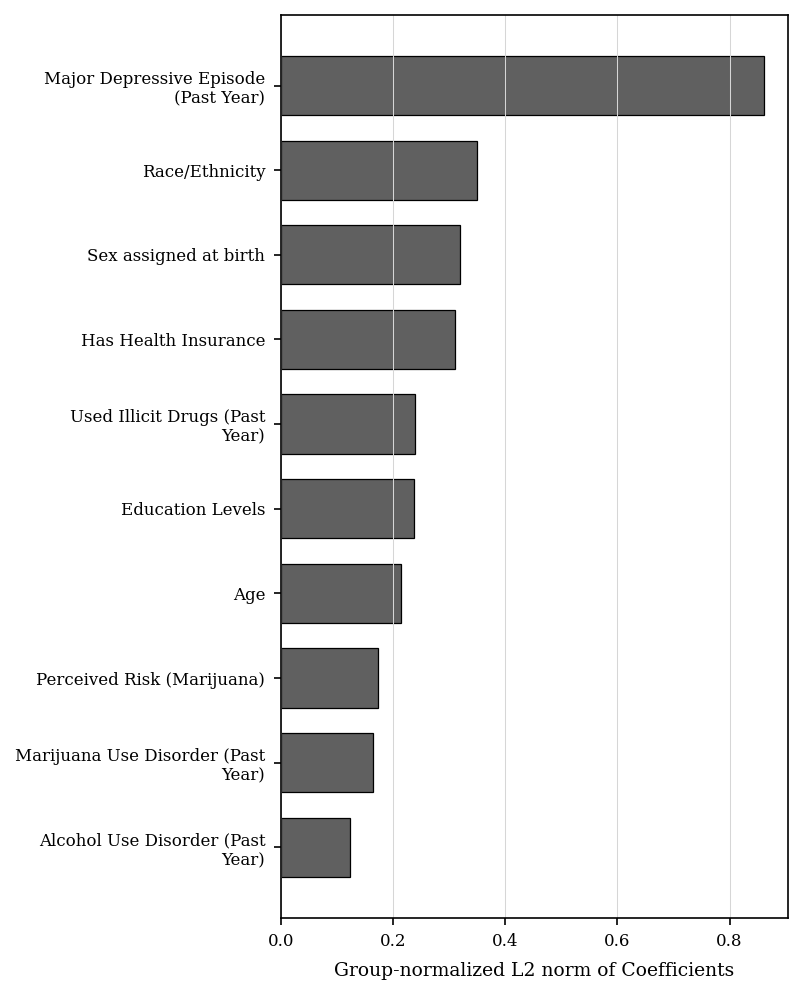

Saved: ../output_reports\MHTRTPY/lasso_output\lasso_MHTRTPY_feature_importance_apa.png
Saved: ../output_reports\MHTRTPY/lasso_output\lasso_MHTRTPY_feature_importance_apa.pdf


In [41]:
plot_lasso_from_export_pretty("MHTRTPY", apa=True)

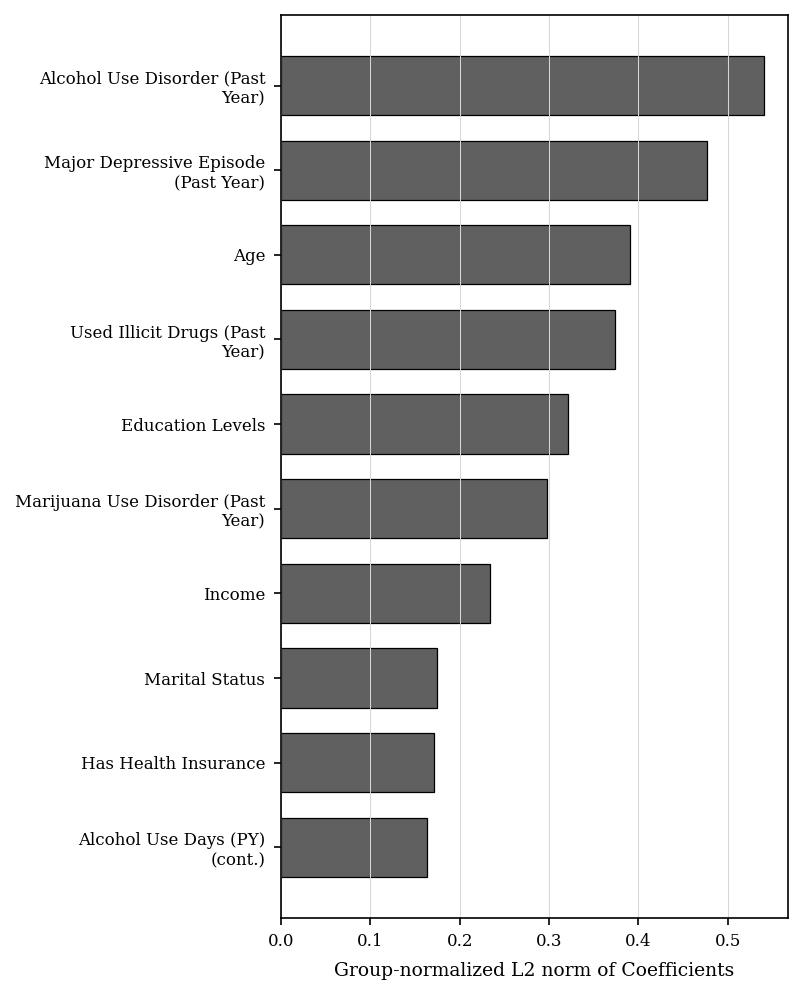

Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance_apa.png
Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance_apa.pdf


In [42]:
plot_lasso_from_export_pretty("SUTRTPY", apa=True)

In [47]:
def plot_group_lasso_trace_from_csv(
    target,
    outdir="../output_reports",
    top_n=None,                 # e.g., show only top 15 groups by max L2
    min_max_l2=0.0,             # or filter by minimum max L2
    wrap_width=28,
    base_figsize=(7.0, 5.5),
    alpha=0.9,
    save=True
):
    """
    Plot group-lasso regularization path (group-level L2 norms) 
    from exported trace CSV instead of in-memory model objects.
    
    Expects a CSV at:
    {outdir}/{target}/group_lasso_output/group_lasso_{target}_trace_data.csv
    with columns:
        group_reg, log10_group_reg, group, var_name, l2_norm, auc, acc, nnz
    """

    # ------------------------------------------------------------------
    # 1. Load trace data
    # ------------------------------------------------------------------
    path = os.path.join(
        outdir,
        f"{target}/group_lasso_output",
        f"group_lasso_{target}_trace_data.csv"
    )
    df = pd.read_csv(path)

    # Sanity checks
    required_cols = {
        "group_reg",
        "log10_group_reg",
        "group",
        "var_name",
        "l2_norm_normed"
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Trace CSV is missing columns: {missing}")

    # ------------------------------------------------------------------
    # 2. Decide which groups to plot
    #    Use max L2 norm across the path as an importance measure
    # ------------------------------------------------------------------
    group_stats = (
        df.groupby(["group", "var_name"], as_index=False)["l2_norm_normed"]
          .max()
          .rename(columns={"l2_norm_normed": "max_l2"})
    )

    # Filter by minimum max L2 if desired
    if min_max_l2 > 0:
        group_stats = group_stats[group_stats["max_l2"] >= min_max_l2]

    # Keep only top_n strongest groups if specified
    if top_n is not None:
        group_stats = group_stats.sort_values("max_l2", ascending=False).head(top_n)

    # Restrict the main df to selected groups
    keep_groups = set(group_stats["group"].tolist())
    df_plot = df[df["group"].isin(keep_groups)].copy()

    # ------------------------------------------------------------------
    # 3. Matplotlib style
    # ------------------------------------------------------------------
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 150,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.family": "serif",
        "font.sans-serif": ["Times New Roman"],
        "font.size": 9,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#d6d6d6",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
    })

    fig, ax = plt.subplots(figsize=base_figsize)

    # ------------------------------------------------------------------
    # 4. Plot trace for each (group, var_name)
    # ------------------------------------------------------------------
    # Ensure groups appear ordered by max_l2 (strongest first in legend)
    group_stats = group_stats.sort_values("max_l2", ascending=False)
    cmap = plt.get_cmap("tab10")  # or "tab20" if many groups

    linestyles = ["-", "--", "-.", ":"]
    for _, row in group_stats.iterrows():
        g = row["group"]
        var_name = row["var_name"]

        df_g = df_plot[df_plot["group"] == g].sort_values("log10_group_reg")

        # Use pretty_label for nicer legend text
        pretty = pretty_label(var_name, wrap=wrap_width)

        ax.plot(
            df_g["log10_group_reg"].values,
            df_g["l2_norm_normed"].values,
            label=pretty,
            alpha=alpha,
            color=cmap(_ % cmap.N),
            linestyle=linestyles[_ % len(linestyles)],
            linewidth=2.0,
        )

    ax.set_xlabel("Regularization Level (log scale)")
    ax.set_ylabel("Group-normalized L2 norm of coefficients")
    #ax.set_title(f"Group Lasso regularization path – {target}")
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.axhline(0, color="black", linewidth=0.5)

    # Legend outside on the right
    ax.legend(
        bbox_to_anchor=(1.05, 1.0),
        loc="upper left",
        fontsize=7,
        frameon=False
    )

    plt.tight_layout()

    # ------------------------------------------------------------------
    # 5. Save to disk (optional)
    # ------------------------------------------------------------------
    if save:
        out_dir = os.path.join(outdir, f"{target}/lasso_output")
        os.makedirs(out_dir, exist_ok=True)

        out_png = os.path.join(out_dir, f"group_lasso_{target}_trace_plot.png")
        out_pdf = os.path.join(out_dir, f"group_lasso_{target}_trace_plot.pdf")

        plt.savefig(out_png, bbox_inches="tight")
        plt.savefig(out_pdf, bbox_inches="tight")

        print(f"Saved trace plot:\n  {out_png}\n  {out_pdf}")

    plt.show()
    return fig, ax

Saved trace plot:
  ../output_reports\MHTRTPY/lasso_output\group_lasso_MHTRTPY_trace_plot.png
  ../output_reports\MHTRTPY/lasso_output\group_lasso_MHTRTPY_trace_plot.pdf


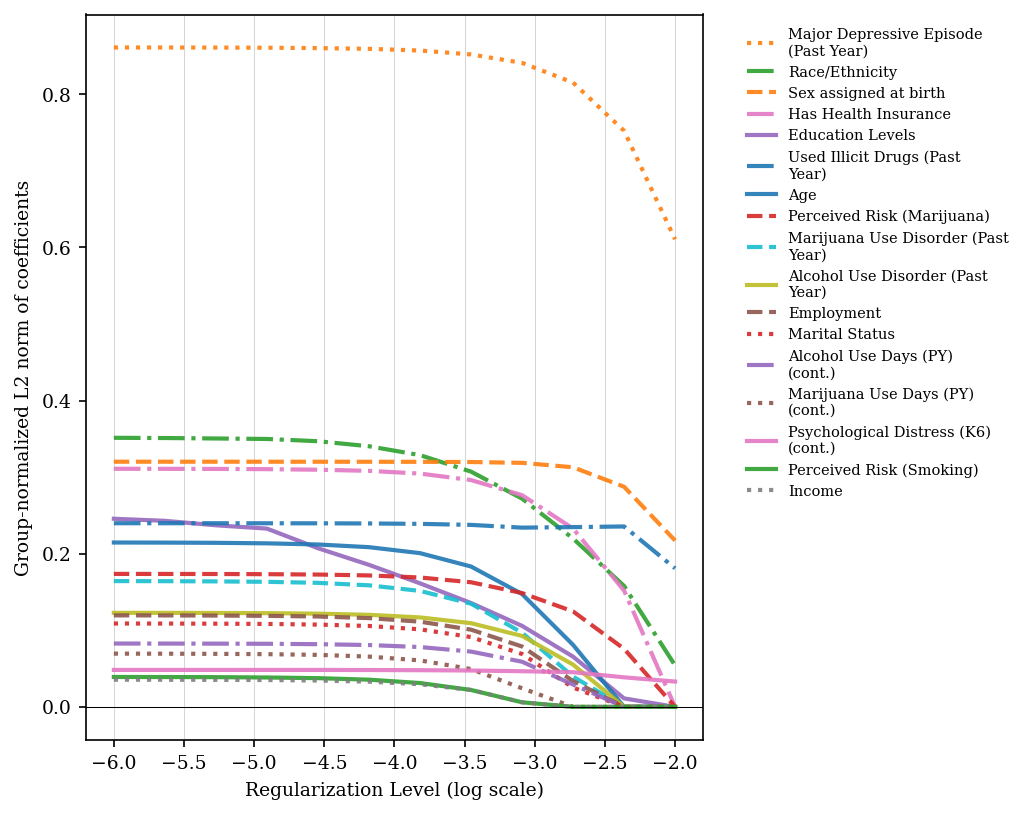

(<Figure size 1050x825 with 1 Axes>,
 <Axes: xlabel='Regularization Level (log scale)', ylabel='Group-normalized L2 norm of coefficients'>)

In [50]:
plot_group_lasso_trace_from_csv("MHTRTPY", top_n=20)

Saved trace plot:
  ../output_reports\SUTRTPY/lasso_output\group_lasso_SUTRTPY_trace_plot.png
  ../output_reports\SUTRTPY/lasso_output\group_lasso_SUTRTPY_trace_plot.pdf


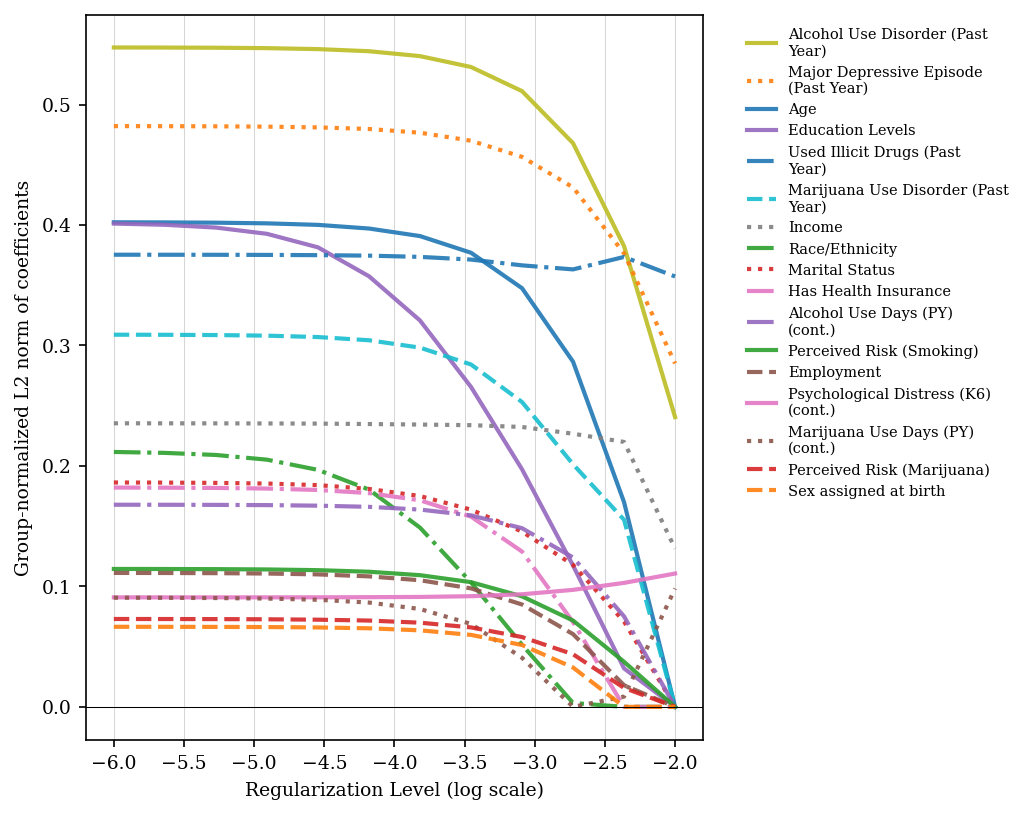

(<Figure size 1050x825 with 1 Axes>,
 <Axes: xlabel='Regularization Level (log scale)', ylabel='Group-normalized L2 norm of coefficients'>)

In [51]:
plot_group_lasso_trace_from_csv("SUTRTPY", top_n=20)

In [52]:
race_map_short = {
    "1": "NH White", "2": "NH Black", "3": "NH Native Am/AK",
    "4": "NH NH/OPI", "5": "NH Asian", "6": "NH ≥2 races", "7": "Hispanic"
}
edu_map_short = {
    "1":"≤5th", "2":"6th", "3":"7th", "4":"8th", "5":"9th", "6":"10th",
    "7":"11-12 (no dip.)", "8":"HS/GED", "9":"Some college",
    "10":"Associate’s", "11":"Bachelor’s+"
}
marital_map_short = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never married"}
work_map_short    = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
pov_map_short     = {"1":"Below poverty","2":"≤2× thresh.","3":">2× thresh."}
risk_map_short    = {"1":"No risk","2":"Slight","3":"Moderate","4":"Great"}
income_map_short  = {"1":"<$20k","2":"$20–49k","3":"$50–74k","4":"$75k+"}

binary_positive = {
    "IRINSUR4": "Has Health Insurance",
    "ILLYR": "Used Illicit Drugs",
    "IRPYUD5ALC": "Has Alcohol Use Disorder",
    "IRPYUD5MRJ": "Has Marijuana Use Disorder",
    "IRAMDEYR": "Has Major Depressive Episode"
}

binary_negative = {
    "IRINSUR4": "No Health Insurance",
    "ILLYR": "No Illicit Drug Use",
    "IRPYUD5ALC": "No Alcohol Use Disorder",
    "IRPYUD5MRJ": "No Marijuana Use Disorder",
    "IRAMDEYR": "No Major Depressive Episode"
}

continuous_nice = {
    "KSSLR6YR": "Psychological Distress (K6)",
    "IRALCFY":  "Alcohol Use Days (PY)",
    "IRMJFY":   "Marijuana Use Days (PY)",
}

def wrap_text(s, width=26):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

def pretty_label(raw_feature, wrap=26):
    f = str(raw_feature)
    if f == "const":
        return "Intercept"

    base, lvl = (f.split("_", 1) + [None])[:2]
    if lvl is not None:
        lvl = lvl.replace(".0", "")

    # continuous
    if base in continuous_nice:
        lab = f"{continuous_nice[base]} (cont.)"
    elif base == "CATAG6":
        lab = f"Age Group: {age_map.get(lvl, lvl)}"
    elif base == "IRSEX":
        lab = f"Sex: {sex_map.get(lvl, lvl)}"
    elif base == "NEWRACE2":
        lab = f"Race/Ethnicity: {race_map_short.get(lvl, lvl)}"
    elif base == "INCOME":
        lab = f"Income: {income_map_short.get(lvl, lvl)}"
    elif base == "IRMARIT":
        lab = f"Marital Status: {marital_map_short.get(lvl, lvl)}"
    elif base == "IREDUHIGHST2":
        lab = f"Education: {edu_map_short.get(lvl, lvl)}"
    elif base == "IRWRKSTAT18":
        lab = f"Employment: {work_map_short.get(lvl, lvl)}"
    elif base == "POVERTY3":
        lab = f"Poverty Status: {pov_map_short.get(lvl, lvl)}"
    elif base == "RSKCIGPKD":
        lab = f"Perceived Risk (Smoking): {risk_map_short.get(lvl, lvl)}"
    elif base == "RSKMRJWK":
        lab = f"Perceived Risk (Marijuana): {risk_map_short.get(lvl, lvl)}"
    elif base in binary_positive and lvl == "1":
        lab = binary_positive[base]
    else:
        lab = f 

    return wrap_text(lab, width=wrap)
def pretty_label_with_ref(raw_feature, wrap=26):
    f = str(raw_feature)
    if f == "const":
        return "Intercept"

    base, lvl = (f.split("_", 1) + [None])[:2]
    if lvl is not None:
        lvl = lvl.replace(".0", "")

    if base in continuous_nice:
        lab = f"{continuous_nice[base]} (cont.)"
        return wrap_text(lab, width=wrap)

    if base == "CATAG6":
        lab = f"Age Group: {age_map.get(lvl, lvl)} (ref: {age_map.get('1', 'code 1')})"
    elif base == "IRSEX":
        lab = f"Sex: {sex_map.get(lvl, lvl)} (ref: {sex_map.get('1', 'code 1')})"
    elif base == "NEWRACE2":
        lab = f"Race/Ethnicity: {race_map_short.get(lvl, lvl)} (ref: {race_map_short.get('1','code 1')})"
    elif base == "INCOME":
        lab = f"Income: {income_map_short.get(lvl, lvl)} (ref: {income_map_short.get('1','code 1')})"
    elif base == "IRMARIT":
        lab = f"Marital Status: {marital_map_short.get(lvl, lvl)} (ref: {marital_map_short.get('1','code 1')})"
    elif base == "IREDUHIGHST2":
        lab = f"Education: {edu_map_short.get(lvl, lvl)} (ref: {edu_map_short.get('1','code 1')})"
    elif base == "IRWRKSTAT18":
        lab = f"Employment: {work_map_short.get(lvl, lvl)} (ref: {work_map_short.get('1','code 1')})"
    elif base == "POVERTY3":
        lab = f"Poverty Status: {pov_map_short.get(lvl, lvl)} (ref: {pov_map_short.get('1','code 1')})"
    elif base == "RSKCIGPKD":
        lab = f"Perceived Risk (Smoking): {risk_map_short.get(lvl, lvl)} (ref: {risk_map_short.get('1','code 1')})"
    elif base == "RSKMRJWK":
        lab = f"Perceived Risk (Marijuana): {risk_map_short.get(lvl, lvl)} (ref: {risk_map_short.get('1','code 1')})"

    elif base in binary_positive and (lvl == "1" or lvl is None):
        lab = f"{binary_positive[base]} (ref: {binary_negative.get(base, '0')})"
    else:
        lab = f"{f} (ref: code 1)"

    return wrap_text(lab, width=wrap)

#### 4.3. Code for GLM plot

In [53]:
def plot_glm_forest_from_export_pretty(
    target,
    outdir="../output_reports",
    top_n=10,                 
    apa=True,
    one_column=False,         
    wrap_width=30,            
    base_height_per_bar=0.55, 
    ci_color="#5a5a5a",       
    point_size=32,
    line_width=2.0,
):
    path = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_or_table.csv")
    df = pd.read_csv(path)


    cand = [c for c in df.columns if c.lower() in {"term","feature","variable","name"}]
    if cand:
        df = df.rename(columns={cand[0]:"term"})
    elif "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0":"term"})
    else:
        df = pd.read_csv(path, index_col=0).reset_index().rename(columns={"index":"term"})

    by_lower = {c.lower(): c for c in df.columns}
    OR = by_lower.get("or")
    L  = by_lower.get("2.5%") or by_lower.get("ci_low")  or by_lower.get("lower")
    U  = by_lower.get("97.5%") or by_lower.get("ci_high") or by_lower.get("upper")
    pval_col = next((c for c in df.columns if c.lower()=="p-value"), None)

    cols = ["term", OR, L, U] + ([pval_col] if pval_col else [])
    df = df[cols].rename(columns={OR:"OR", L:"2.5%", U:"97.5%"})


    df = df[df["term"]!="const"].copy()
    for c in ["OR","2.5%","97.5%"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").clip(lower=1e-12)
    df["logOR"] = np.log(df["OR"])
    df["abs_logOR"] = df["logOR"].abs()

    df = df.sort_values("abs_logOR", ascending=False).head(top_n).copy()

    df = df.sort_values("logOR", ascending=True).reset_index(drop=True)

    df["Pretty"] = df["term"].apply(lambda s: pretty_label_with_ref(s, wrap=999))
    df["Pretty_wrapped"] = df["Pretty"].apply(lambda s: "\n".join(textwrap.wrap(s, width=wrap_width)))

    width_in = 3.5 if one_column else 6.5
    height_in = max(4.5, base_height_per_bar * len(df) + 1.0)

    mpl.rcParams.update({
        "figure.dpi": 150, "savefig.dpi": 150,
        "pdf.fonttype": 42, "ps.fonttype": 42,        
        "font.family": "serif",
        "font.sans-serif": ["Times New Roman"],
        "font.size": 9,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#d6d6d6",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
    })

    fig, ax = plt.subplots(figsize=(width_in, height_in))


    y = np.arange(len(df))[::-1]


    ax.hlines(y=y, xmin=df["2.5%"], xmax=df["97.5%"], color=ci_color, lw=line_width, alpha=1.0)
    ax.scatter(df["OR"], y, s=point_size, color=ci_color, zorder=3)

    ax.axvline(1.0, color="black", linestyle="--", lw=0.8, alpha=0.8)
    ax.set_yticks(y)
    ax.set_yticklabels(df["Pretty_wrapped"])
    ax.set_xscale("log")
    ax.set_xlabel("Odds Ratio (log scale)", labelpad=6)
    ax.set_ylabel("")
    ax.set_title("") 

    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

    ax.tick_params(axis="y", labelsize=8, pad=4)
    ax.tick_params(axis="x", labelsize=8)

    xmin = df["2.5%"].min()
    xmax = df["97.5%"].max()
    ax.set_xlim(xmin * 0.9, xmax * 1.1)

    ax.set_yticks(y)
    ax.set_yticklabels(df["Pretty_wrapped"])
    ax.invert_yaxis()   

    from matplotlib.ticker import LogLocator, NullFormatter


    ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1]))

    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 5], numticks=10))

    plt.subplots_adjust(left=0.46, right=0.98, top=0.98, bottom=0.12)

    out_dir = os.path.join(outdir, f"{target}/glm_output")
    os.makedirs(out_dir, exist_ok=True)
    out_png = os.path.join(out_dir, f"glm_{target}_forest_apa.png")
    out_pdf = os.path.join(out_dir, f"glm_{target}_forest_apa.pdf")
    plt.savefig(out_png, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    print("Saved:", out_png)
    print("Saved:", out_pdf)


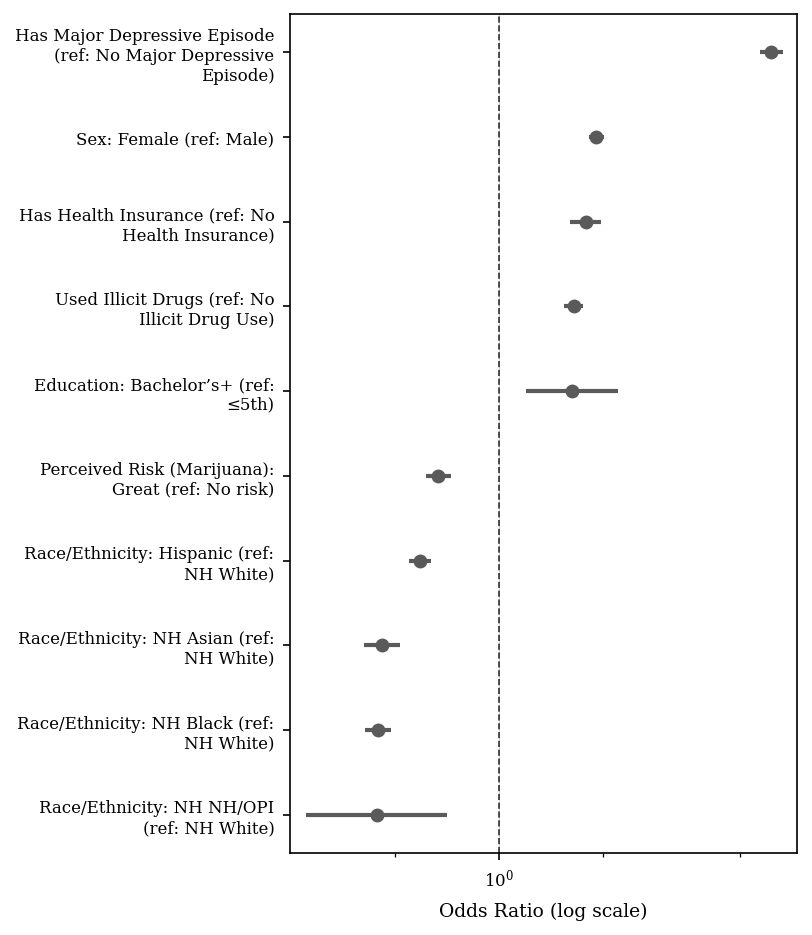

Saved: ../output_reports\MHTRTPY/glm_output\glm_MHTRTPY_forest_apa.png
Saved: ../output_reports\MHTRTPY/glm_output\glm_MHTRTPY_forest_apa.pdf


In [54]:
plot_glm_forest_from_export_pretty("MHTRTPY")  

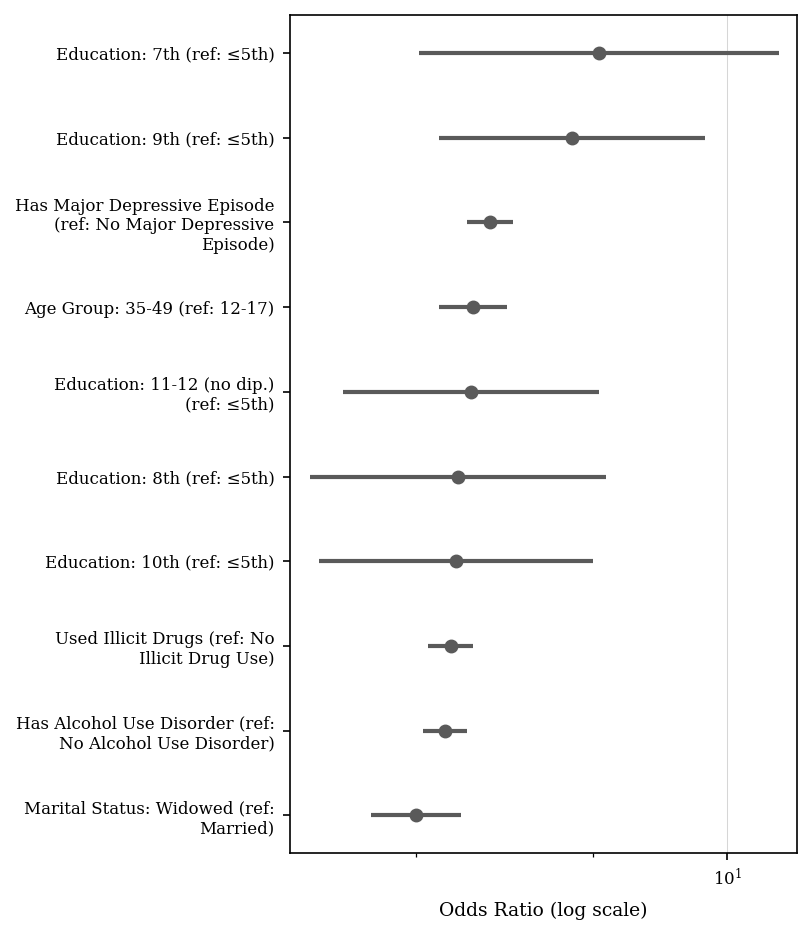

Saved: ../output_reports\SUTRTPY/glm_output\glm_SUTRTPY_forest_apa.png
Saved: ../output_reports\SUTRTPY/glm_output\glm_SUTRTPY_forest_apa.pdf


In [60]:
plot_glm_forest_from_export_pretty("SUTRTPY")  

#### 4.4. Code for Random Forest plot

In [57]:
def plot_random_forest_from_export_pretty(
    target,
    outdir="../output_reports",
    top_n=10,                 
    apa=True,
    one_column=False,       
    wrap_width=28,
    base_height_per_bar=0.6,  
):
    path = os.path.join(outdir, f"{target}/rf_output", f"rf_{target}_feature_importance.csv")
    df = pd.read_csv(path).rename(columns={"feature":"Feature","importance":"Importance"})
    df["AbsCoef"] = df["Importance"].abs()
    df = df.sort_values("AbsCoef", ascending=False).head(top_n).copy()
    df["Pretty"] = df["Feature"].apply(pretty_label_with_ref)

    df["Pretty_wrapped"] = df["Pretty"].apply(lambda s: "\n".join(textwrap.wrap(s, width=wrap_width)))

    width_in = 6.5
    height_in = max(4.5, base_height_per_bar * len(df) + 1.0)

    mpl.rcParams.update({
        "figure.dpi": 150, "savefig.dpi": 150,
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "font.family": "serif",
        "font.sans-serif": ["Times New Roman"],
        "font.size": 9,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#d6d6d6",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
    })

    fig, ax = plt.subplots(figsize=(width_in, height_in))
    bars = ax.barh(
        df["Pretty_wrapped"],
        df["AbsCoef"],
        color="#606060",
        edgecolor="black",
        linewidth=0.6,
        height=0.7
    )
    ax.invert_yaxis()

    ax.set_xlabel("Feature Importance", labelpad=6)
    ax.set_ylabel("")
    ax.set_title("") 

    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

    ax.tick_params(axis="y", labelsize=8, pad=4)
    ax.tick_params(axis="x", labelsize=8)

    plt.subplots_adjust(left=0.46, right=0.98, top=0.98, bottom=0.12)

    out_dir = os.path.join(outdir, f"{target}/rf_output")
    os.makedirs(out_dir, exist_ok=True)
    suffix = "apa"
    out_png = os.path.join(out_dir, f"rf_{target}_feature_importance_{suffix}.png")
    out_pdf = os.path.join(out_dir, f"rf_{target}_feature_importance_{suffix}.pdf")

    plt.savefig(out_png, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    print(f"Saved: {out_png}\nSaved: {out_pdf}")


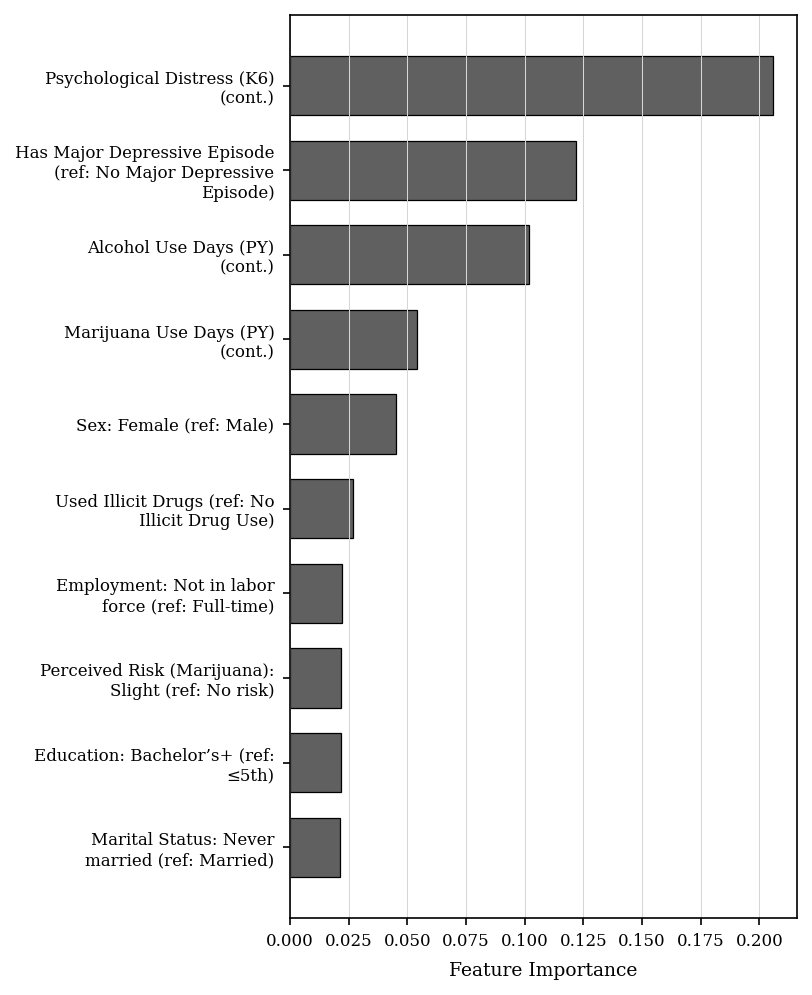

Saved: ../output_reports\MHTRTPY/rf_output\rf_MHTRTPY_feature_importance_apa.png
Saved: ../output_reports\MHTRTPY/rf_output\rf_MHTRTPY_feature_importance_apa.pdf


In [58]:
plot_random_forest_from_export_pretty("MHTRTPY", apa=True)

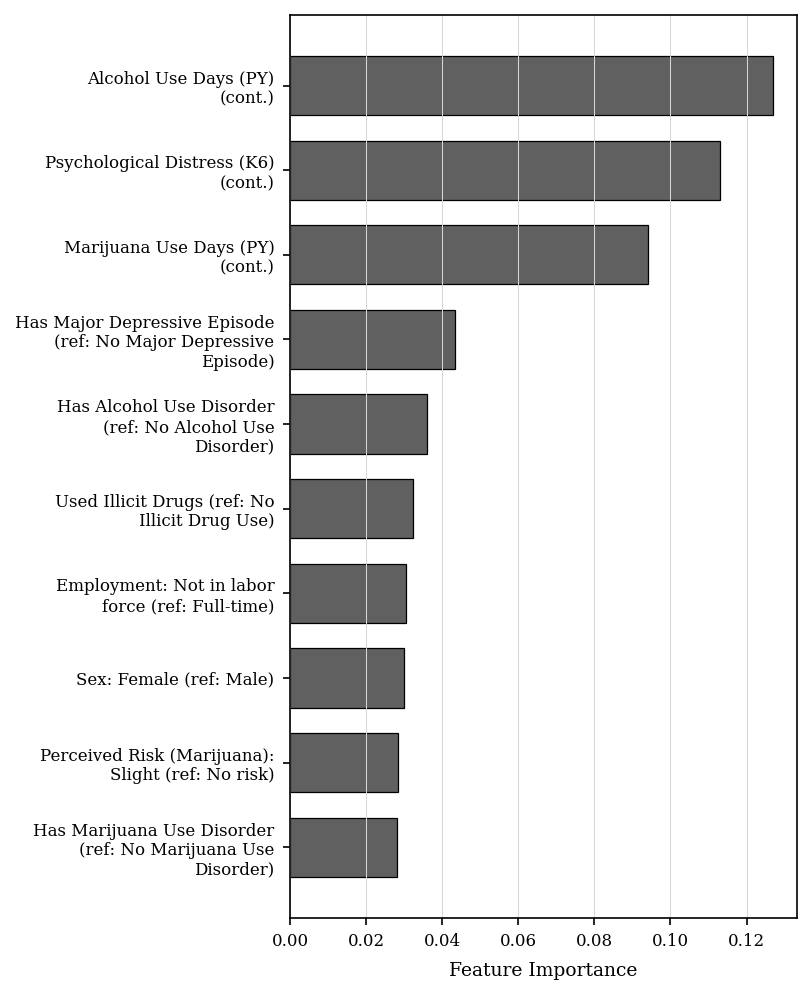

Saved: ../output_reports\SUTRTPY/rf_output\rf_SUTRTPY_feature_importance_apa.png
Saved: ../output_reports\SUTRTPY/rf_output\rf_SUTRTPY_feature_importance_apa.pdf


In [59]:
plot_random_forest_from_export_pretty("SUTRTPY", apa=True)

In [35]:
def plot_apa_hist(
    data: pd.DataFrame,
    col: str,
    weights: pd.Series | None = None,  
    outdir: str = "../output_reports/hist",
    x_label: str | None = None,
    binwidth: int | None = 7,          
    bins: int | None = None,            
    xlim: tuple[int, int] | None = (0, 365),
    one_column: bool = False,       
    show_grid: bool = True,
    file_tag: str | None = None,     
):
    s = pd.to_numeric(data[col], errors="coerce").dropna()
    if xlim:
        s = s[(s >= xlim[0]) & (s <= xlim[1])]

    w = None
    if weights is not None:
        w = weights.loc[s.index].astype(float)
        # Normalize to sum to 100 so heights are percentages
        w = (w / w.sum()) * 100
    else:
        # Unweighted: each sample counts equally toward percentages
        w = np.repeat(100.0 / len(s), len(s))

    # Binning
    if binwidth is not None and xlim is not None:
        edges = np.arange(xlim[0], xlim[1] + binwidth, binwidth)
    else:
        # fallback to a reasonable automatic rule
        edges = bins if bins is not None else "fd"

    # APA rcParams
    mpl.rcParams.update({
        "figure.dpi": 150, "savefig.dpi": 150,
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "font.family": "serif",
        "font.sans-serif": ["Times New Roman"],
        "font.size": 9,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": show_grid,
        "grid.color": "#d6d6d6",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
    })

    width_in = 3.5 if one_column else 6.5
    height_in = 4.0
    fig, ax = plt.subplots(figsize=(width_in, height_in))

    ax.hist(s, bins=edges, weights=w, color="#6a6a6a", edgecolor="black", linewidth=0.6)
    ax.set_ylabel("Percent", labelpad=6)
    ax.set_xlabel(x_label if x_label else col, labelpad=6)
    if xlim: ax.set_xlim(*xlim)

    # y-axis as nice percents
    yt = ax.get_yticks()
    ax.set_yticklabels([f"{t:.0f}%" for t in yt])

    # clean spines and layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", visible=show_grid)
    ax.grid(axis="x", visible=False)
    plt.tight_layout()

    # Save
    os.makedirs(outdir, exist_ok=True)
    tag = f"_{file_tag}" if file_tag else ""
    png = os.path.join(outdir, f"hist_{col}{tag}.png")
    pdf = os.path.join(outdir, f"hist_{col}{tag}.pdf")
    plt.savefig(png, bbox_inches="tight")
    plt.savefig(pdf, bbox_inches="tight")
    plt.show()
    print("Saved:", png)
    print("Saved:", pdf)

C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2819321019.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{t:.0f}%" for t in yt])


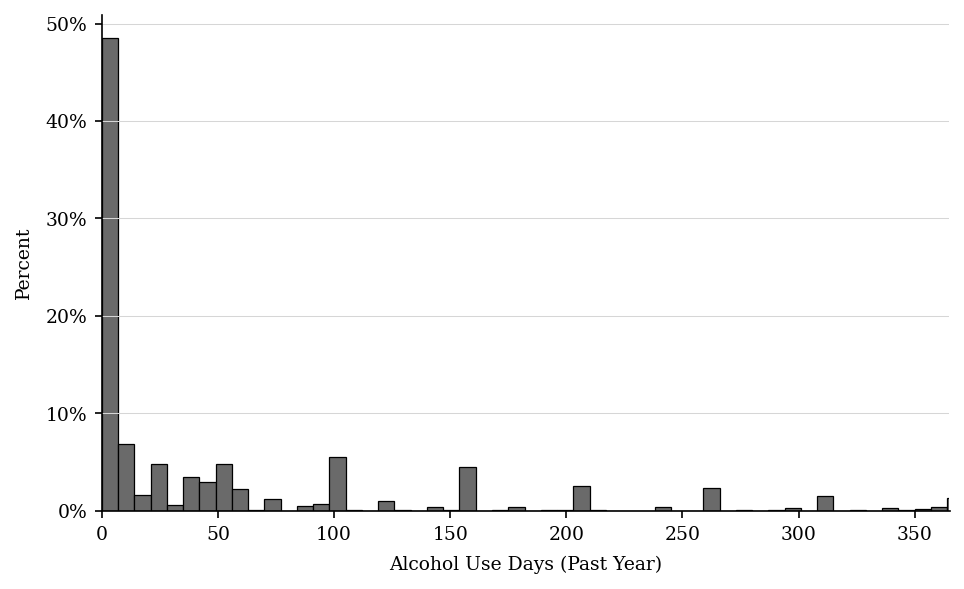

Saved: ../output_reports/hist\hist_IRALCFY_weighted.png
Saved: ../output_reports/hist\hist_IRALCFY_weighted.pdf


C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2819321019.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{t:.0f}%" for t in yt])


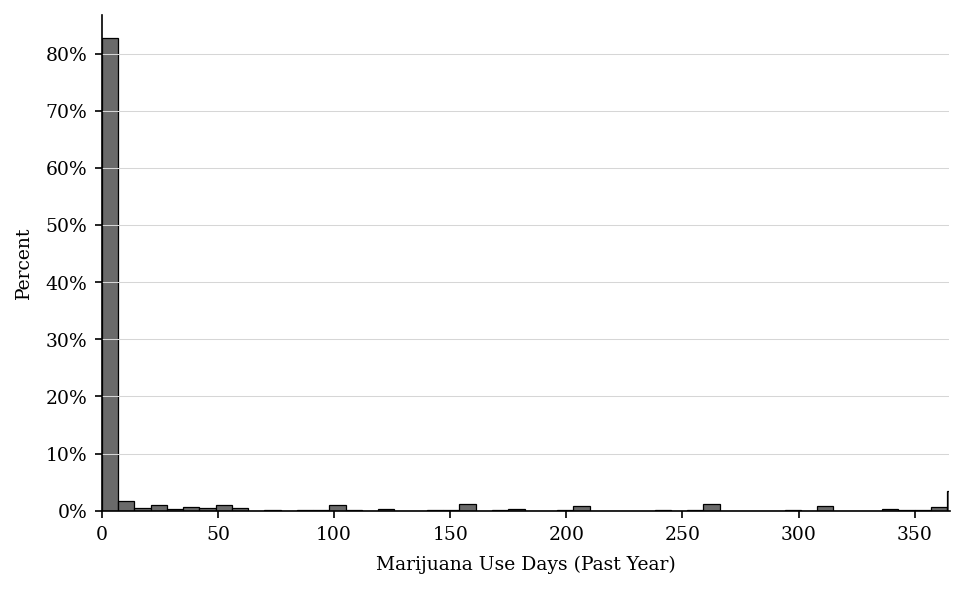

Saved: ../output_reports/hist\hist_IRMJFY_weighted.png
Saved: ../output_reports/hist\hist_IRMJFY_weighted.pdf


C:\Users\Admin\AppData\Local\Temp\ipykernel_33060\2819321019.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{t:.0f}%" for t in yt])


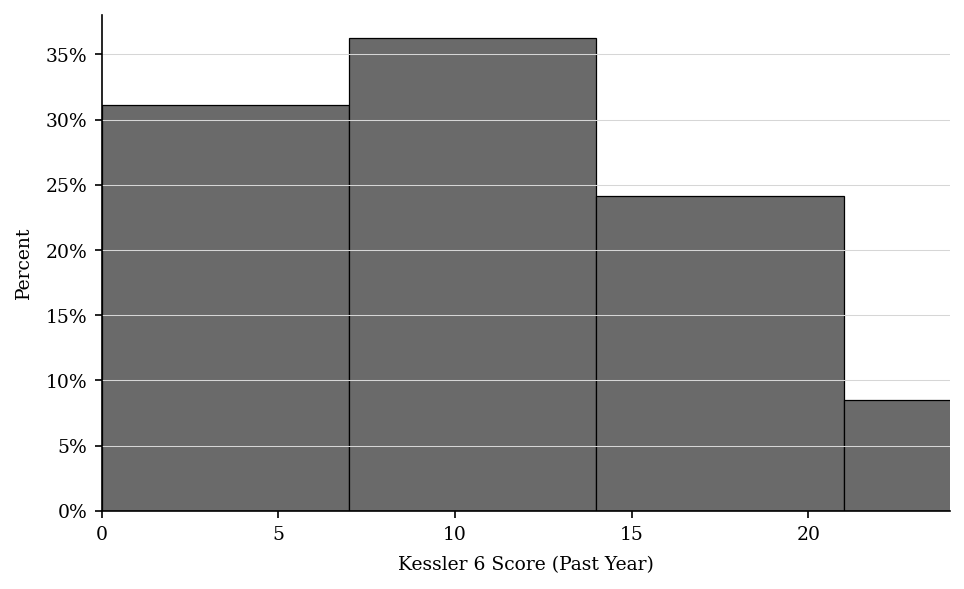

Saved: ../output_reports/hist\hist_KSSLR6YR_weighted.png
Saved: ../output_reports/hist\hist_KSSLR6YR_weighted.pdf


In [36]:
# Alcohol use days (past year)
plot_apa_hist(
    data=df,
    col="IRALCFY",
    weights=df["ANALWT2_C"],      
    outdir="../output_reports/hist",
    x_label="Alcohol Use Days (Past Year)",
    binwidth=7,                       
    xlim=(0, 365),
    file_tag="weighted"
)

# Marijuana use days (past year)
plot_apa_hist(
    data=df,
    col="IRMJFY",
    weights=df["ANALWT2_C"],
    outdir="../output_reports/hist",
    x_label="Marijuana Use Days (Past Year)",
    binwidth=7,
    xlim=(0, 365),
    file_tag="weighted"
)

plot_apa_hist(
    data=df,
    col="KSSLR6YR",
    weights=df["ANALWT2_C"],
    outdir="../output_reports/hist",
    x_label="Kessler 6 Score (Past Year)",
    binwidth=7,
    xlim=(0, 24),
    file_tag="weighted"
)